# Sentiment analysis using Twitter streams

Simple analysis using parsing of English messages on Twitter.
Scores are evaluated using the AFINN base

# Get Twitter data

In [2]:
import sys
import json

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

import seaborn as sns

# Utils

In [3]:
afinnfile = open("AFINN-111.txt")

scores = {}
for line in afinnfile:
   term, score  = line.split("\t")  #file is tab-delimited
   scores[term] = int(score)

In [4]:
scores.items()[:10]

[('limited', -1),
 ('suicidal', -2),
 ('pardon', 2),
 ('desirable', 2),
 ('protest', -2),
 ('lurking', -1),
 ('controversial', -2),
 ('hating', -3),
 ('ridiculous', -3),
 ('hate', -3)]

In [5]:
states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}


# Tweet text parsing

In [6]:
tweet_file = open("output.json")
tweet_text_dict = {} # dictionary : key = tweet texts, value = sentiment
state_score = {} # key = state, value = sentiment score

for line in tweet_file:
    curr_tweet = json.loads(line)
    
    try:
        if 'text' in curr_tweet : #if 'text' field exists
    
            if 'lang' in curr_tweet:
                if curr_tweet['lang'] == 'en':   # select tweets tagged in English
                    #sentiment score
                    tweet_text = curr_tweet['text']
                    sentiment = 0
                    for word in range(len(tweet_text.split())):
                        if tweet_text.split()[word] in scores:
                            sentiment += scores[tweet_text.split()[word]]
                    tweet_text_dict[tweet_text] = sentiment
                    
                    #score according to location
                    if 'user' in curr_tweet:
                        if 'location' in curr_tweet['user']:
                                location_str = str(curr_tweet['user']['location'])
                                for location in range(len(location_str.split())):
                                    if location_str.split()[location] in states:
                                        if location_str.split()[location] in state_score :
                                            state_score[location_str.split()[location]] += sentiment
                                        else : state_score[location_str.split()[location]] = sentiment
   
    except UnicodeEncodeError: continue #ignore non-Western characters

# Information retrieval

## Derive the sentiment of each tweet using AFINN-111

In [7]:
tweet_df = pd.DataFrame(tweet_text_dict.items(),columns=['tweet', 'sentiment'])

In [8]:
tweet_df.head(5)

,tweet,sentiment
0,KYAAAAAAAAAAAAA!!! Sehun performed The dance w...,0
1,Well done is better than well said. (Benjamin ...,2
2,RT @dichi08: Never let the things you want mak...,0
3,RT @insideaflower: Henrik teaching geography b...,0
4,Check out my Junior Season Highlights! 🌪🏈 - ht...,0


## Derive the sentiment of new terms not in AFINN-111

In [9]:
scores_not_AFINN = {} # key = word not in AFINN, value = score

New terms get affected with global sentiment score of tweet - provided that tweet contains words in AFINN (very lazy method)

In [10]:
for key in tweet_text_dict: 
    if tweet_text_dict[key] != 0 :  #tweets w/ AFINN terms 
        for j in range(len(key.split())):
            if key.split()[j] in scores:continue
            else : scores_not_AFINN[key.split()[j]] = tweet_text_dict[key]

In [11]:
scores_not_AFINN_df = pd.DataFrame(scores_not_AFINN.items(),columns=['term', 'sentiment'])

In [12]:
scores_not_AFINN_df.head(5)

,term,sentiment
0,fawn,-3
1,https://t.co/vOnbJCV4Wa,-3
2,https://t.co/mynFI8UPRl,2
3,JN:,1
4,@wef:,3


## Term frequency histogram

In [13]:
N = 100 # N most frequent terms

In [14]:
term_occurences = {}
for tweet in tweet_df.tweet:
    for term in range(len(tweet.split())):
        #
        # convert to lowercase
        #if tweet.split()[term] in stop_words:
        #    continue
        #
        if tweet.split()[term] in term_occurences:
            term_occurences[tweet.split()[term]] += 1 #add term occurence
        else: term_occurences[tweet.split()[term]] = 1 #1st encountered

most_frequent = []
for i in range(N):
    most_frequent.append(sorted(term_occurences.items(), key=lambda x: x[1], reverse = True)[i])

In [15]:
most_frequent_df = pd.DataFrame(most_frequent, columns=['term', 'frequency'])

Text(0,0.5,u'Frequency')

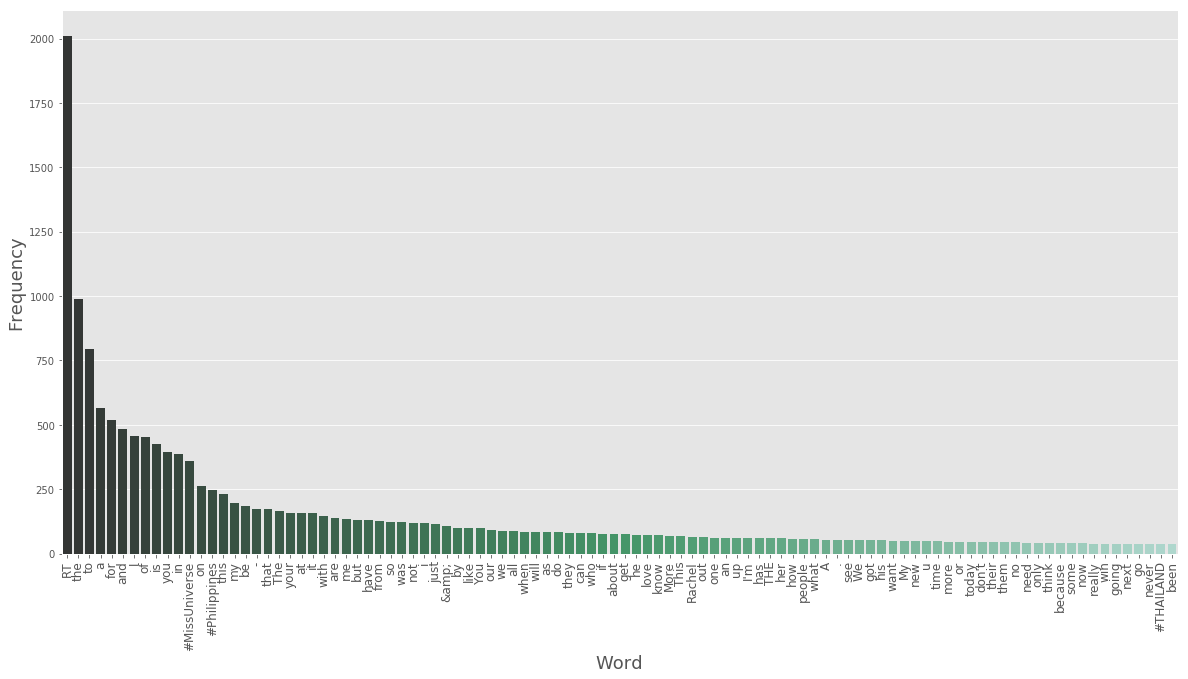

In [16]:
word_list=[]
for word in most_frequent_df['term'].values:
    word_list.append(str(word))
    
x = most_frequent_df.index
y = most_frequent_df['frequency']
x_ticks_labels = word_list

fig, ax = plt.subplots(figsize=(20,10))
#ax.bar(x,y)
sns.barplot(x, y, ci=None, palette="BuGn_d")#, hline=.1)#, ax=ax)
ax.set_xticks(x)
ax.set_xticklabels(x_ticks_labels, rotation = 'vertical', fontsize=12)
ax.set_xlabel('Word', fontsize=18)
ax.set_ylabel('Frequency', fontsize=18)

## Score happiness throughout US states

In [17]:
if state_score.items():
    state_score_sorted_list = []
    state_score_sorted_list = sorted(state_score.items(), key=lambda x: x[1], reverse = True)
    print state_score_sorted_list

[('GA', 23), ('FL', 16), ('MI', 8), ('KS', 8), ('NV', 7), ('CO', 6), ('DC', 5), ('TX', 5), ('LA', 5), ('AZ', 5), ('WV', 4), ('NY', 4), ('AR', 4), ('IL', 4), ('RI', 4), ('NE', 3), ('IN', 3), ('IA', 3), ('OH', 3), ('WA', 2), ('DE', 2), ('CA', 2), ('AL', 2), ('MO', 2), ('MN', 2), ('NC', 1), ('TN', 1), ('VA', 1), ('OR', 1), ('WI', 0), ('NH', 0), ('NJ', 0), ('AS', 0), ('CT', 0), ('ME', 0), ('MA', 0), ('KY', 0), ('AK', -1), ('PA', -6), ('SC', -9), ('MD', -14)]


In [18]:
state_score_df = pd.DataFrame(state_score_sorted_list, columns=['state', 'happiness score'])

Text(0,0.5,u'Happiness score')

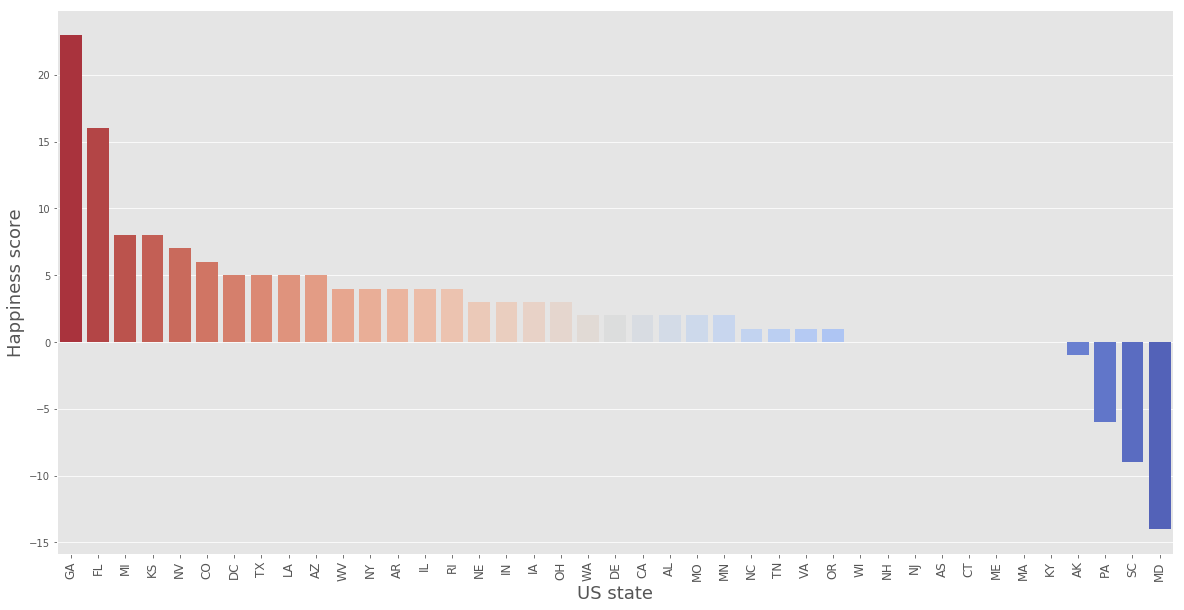

In [19]:
state_list=[]
for state in state_score_df['state'].values:
    state_list.append(str(state))
    
x = state_score_df.index
y = state_score_df['happiness score']
x_ticks_labels = state_list

fig, ax = plt.subplots(figsize=(20,10))
#ax.bar(x,y)

sns.barplot(x, y, ci=None, palette="coolwarm_r")#, hline=0), ax=ax2)
ax.set_xticks(x)
ax.set_xticklabels(x_ticks_labels, rotation = 'vertical', fontsize=12)
ax.set_xlabel('US state', fontsize=18)
ax.set_ylabel('Happiness score', fontsize=18)